In [25]:
import pandas as pd

In [26]:
df = pd.read_csv("C:/bestSelling_games.csv")

In [27]:
#TASK 1

In [28]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

In [29]:
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month

In [30]:
df.head()

,game_name,reviews_like_rate,all_reviews_number,release_date,developer,user_defined_tags,supported_os,supported_languages,price,other_features,age_restriction,rating,difficulty,length,estimated_downloads,release_year,release_month
0,Counter-Strike 2,86,8803754,2012-08-21,Valve,"FPS, Action, Tactical","win, linux","English, Czech, Danish, Dutch, Finnish, French...",0.00,"Cross-Platform Multiplayer, Steam Trading Card...",17,3.20,4,80,306170000,2012,8
1,PUBG: BATTLEGROUNDS,59,2554482,2017-12-21,PUBG Corporation,"Survival, Shooter, Action, Tactical",win,"English, Korean, Simplified Chinese, French, G...",0.00,"Online PvP, Stats, Remote Play on Phone, Remot...",13,3.10,4,73,162350000,2017,12
2,ELDEN RING NIGHTREIGN,77,53426,2025-05-30,"FromSoftware, Inc.","Souls-like, Open World, Fantasy, RPG",win,"English, Japanese, French, Italian, German, Sp...",25.99,"Single-player, Online Co-op, Steam Achievement...",17,3.96,4,50,840000,2025,5
3,The Last of Us™ Part I,79,45424,2023-03-28,Naughty Dog LLC,"Story Rich, Shooter, Survival, Horror",win,"English, Italian, Spanish - Spain, Czech, Dutc...",59.99,"Single-player, Steam Achievements, Steam Tradi...",17,4.10,3,24,2000000,2023,3
4,Red Dead Redemption 2,92,672140,2019-12-05,Rockstar Games,"Open World, Story Rich, Adventure, Realistic, ...",win,"English, French, Italian, German, Spanish - Sp...",59.99,"Single-player, Online PvP, Online Co-op, Steam...",17,4.32,3,80,21610000,2019,12


In [31]:
df[['price', 'difficulty', 'rating']].isnull().sum()

price         0
difficulty    0
rating        0
dtype: int64

In [32]:
df['price'] = df['price'].astype(float)

bins = [-0.1, 0, 10, 30, float('inf')]
labels = ['Free', '<$10', '$10–30', '>$30']

df['price_range'] = pd.cut(df['price'], bins=bins, labels=labels)

print(df[['price', 'price_range']].head())

   price price_range
0   0.00        Free
1   0.00        Free
2  25.99      $10–30
3  59.99        >$30
4  59.99        >$30


In [33]:
from sklearn.preprocessing import MultiLabelBinarizer

def split_tags(x):
    if isinstance(x, list):
        return x  # it's already split
    if pd.isna(x):
        return []
    return [tag.strip() for tag in x.split(',')]

df['user_defined_tags'] = df['user_defined_tags'].apply(split_tags)
df['supported_os'] = df['supported_os'].apply(split_tags)
df['other_features'] = df['other_features'].apply(split_tags)

mlb = MultiLabelBinarizer()

tags_df = pd.DataFrame(mlb.fit_transform(df['user_defined_tags']), columns=mlb.classes_)
os_df = pd.DataFrame(mlb.fit_transform(df['supported_os']), columns=mlb.classes_)
features_df = pd.DataFrame(mlb.fit_transform(df['other_features']), columns=mlb.classes_)

tags_df = tags_df.add_prefix('tag_')
os_df = os_df.add_prefix('os_')
features_df = features_df.add_prefix('feat_')

df = pd.concat([df, tags_df, os_df, features_df], axis=1)

In [34]:
#TASK 2

In [35]:
subset = df[['all_reviews_number', 'reviews_like_rate', 'rating', 'estimated_downloads']]

correlation = subset.corr(numeric_only=True)
print(correlation)

                     all_reviews_number  reviews_like_rate    rating  \
all_reviews_number             1.000000           0.041926  0.079721   
reviews_like_rate              0.041926           1.000000  0.534457   
rating                         0.079721           0.534457  1.000000   
estimated_downloads            0.863408           0.031049  0.119670   

                     estimated_downloads  
all_reviews_number              0.863408  
reviews_like_rate               0.031049  
rating                          0.119670  
estimated_downloads             1.000000  


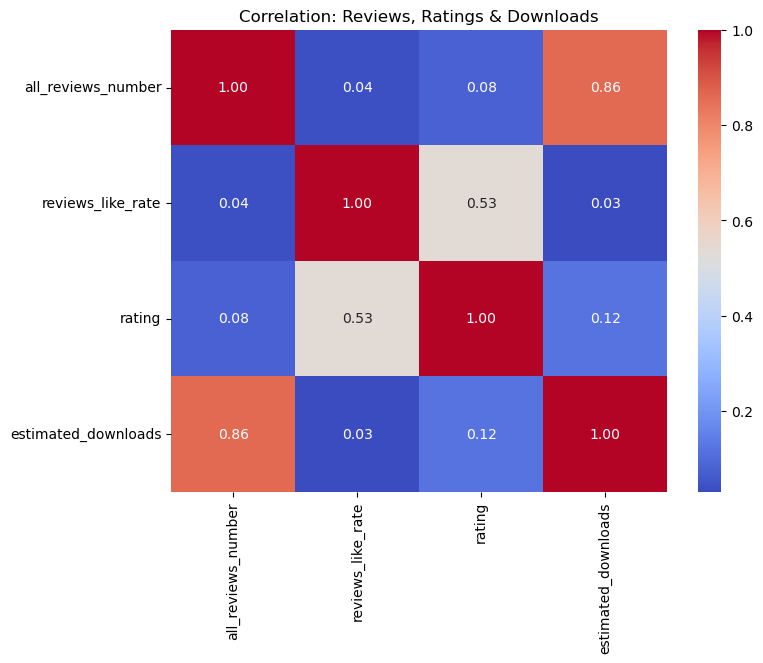

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation: Reviews, Ratings & Downloads')
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_41828\1308865370.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


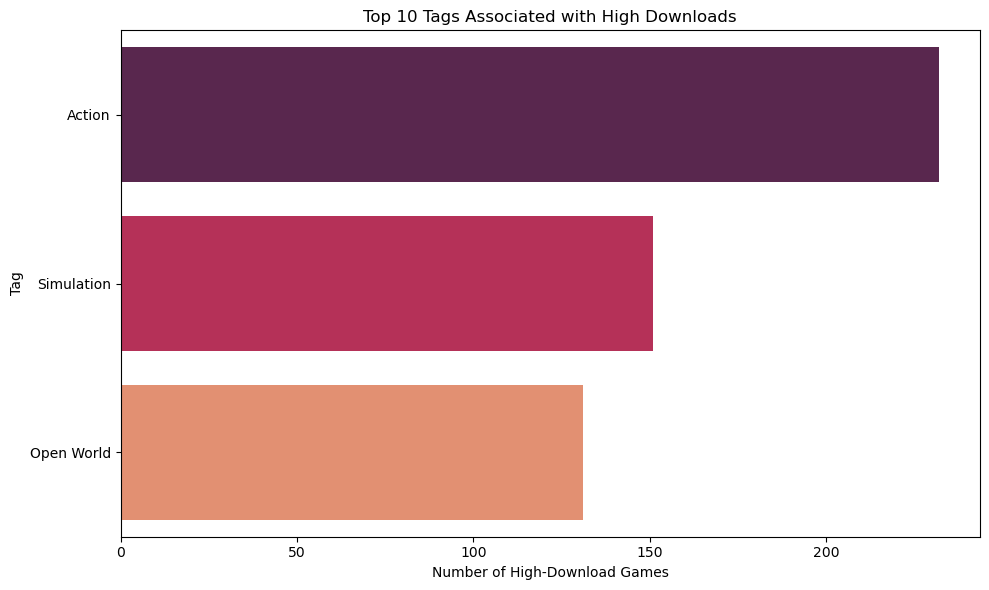

In [40]:
# Step 1: Calculate threshold for high downloads (top 25%)
threshold = df['estimated_downloads'].quantile(0.75)

# Step 2: Filter high download games
high_downloads_df = df[df['estimated_downloads'] >= threshold]

# Step 3: Identify tag columns
tag_cols = [col for col in df.columns if col.startswith('tag_')]

# Step 4: Count how often each tag appears in high-download games
high_tag_counts = high_downloads_df[tag_cols].sum().sort_values(ascending=False)

# Step 5: Plot top 10 tags
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(
    x=high_tag_counts.head(10).values,
    y=high_tag_counts.head(10).index.str.replace('tag_', ''),
    palette='rocket'
)
plt.title('Top 10 Tags Associated with High Downloads')
plt.xlabel('Number of High-Download Games')
plt.ylabel('Tag')
plt.tight_layout()
plt.show()

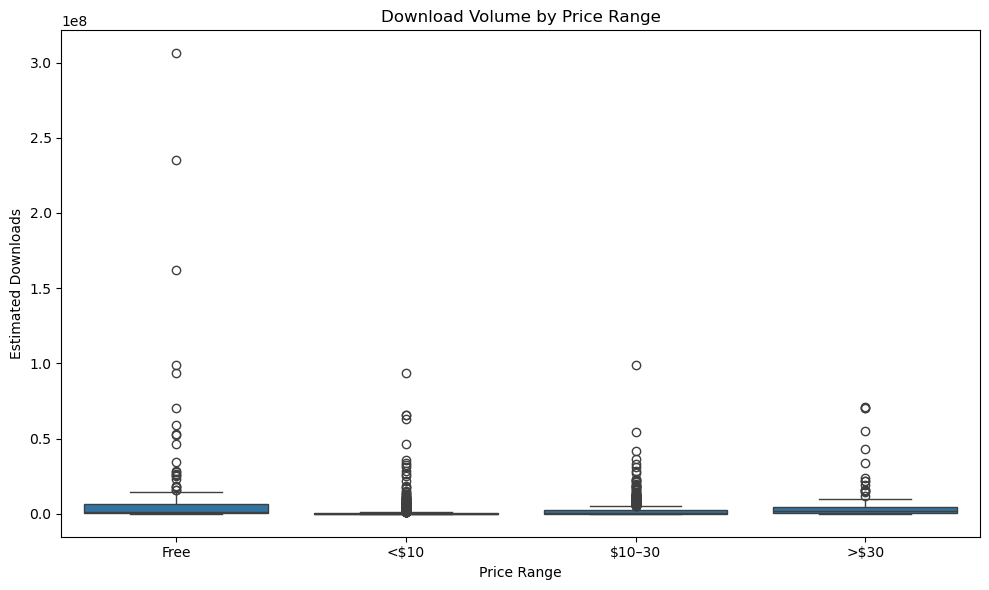

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='price_range', y='estimated_downloads', data=df)
plt.title('Download Volume by Price Range')
plt.xlabel('Price Range')
plt.ylabel('Estimated Downloads')
plt.tight_layout()
plt.show()

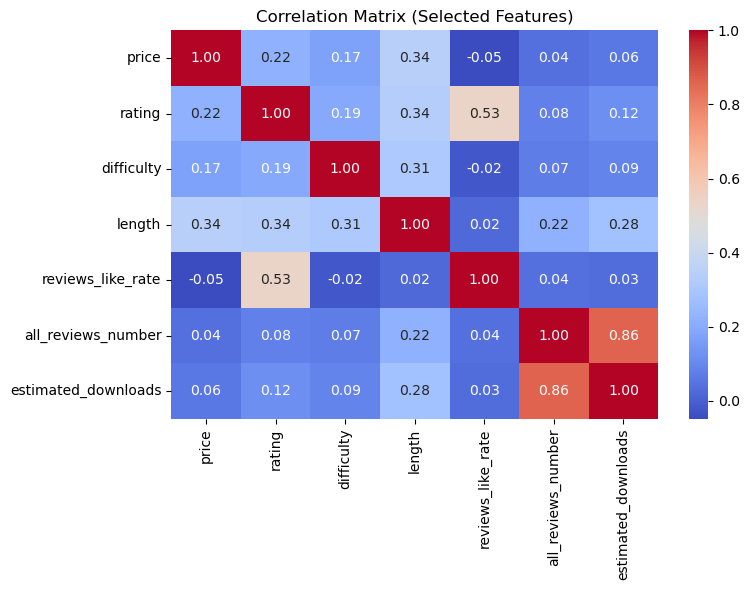

In [39]:
selected_cols = [
    'price', 'rating', 'difficulty', 'length',
    'reviews_like_rate', 'all_reviews_number',
    'estimated_downloads'
]
corr_matrix = df[selected_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix (Selected Features)')
plt.tight_layout()
plt.show()

In [41]:
#TASK 3

In [42]:
df['is_free'] = (df['price'] == 0).astype(int)

In [43]:
df.head()

,game_name,reviews_like_rate,all_reviews_number,release_date,developer,user_defined_tags,supported_os,supported_languages,price,other_features,...,tag_Sports,tag_Stealth,tag_Story Rich,tag_Strategy,tag_Survival,tag_Tactical,tag_Turn-Based,tag_Visual Novel,tag_War,is_free
0,Counter-Strike 2,86,8803754,2012-08-21,Valve,"[FPS, Action, Tactical]","[win, linux]","English, Czech, Danish, Dutch, Finnish, French...",0.00,"[Cross-Platform Multiplayer, Steam Trading Car...",...,0,0,0,0,0,1,0,0,0,1
1,PUBG: BATTLEGROUNDS,59,2554482,2017-12-21,PUBG Corporation,"[Survival, Shooter, Action, Tactical]",[win],"English, Korean, Simplified Chinese, French, G...",0.00,"[Online PvP, Stats, Remote Play on Phone, Remo...",...,0,0,0,0,1,1,0,0,0,1
2,ELDEN RING NIGHTREIGN,77,53426,2025-05-30,"FromSoftware, Inc.","[Souls-like, Open World, Fantasy, RPG]",[win],"English, Japanese, French, Italian, German, Sp...",25.99,"[Single-player, Online Co-op, Steam Achievemen...",...,0,0,0,0,0,0,0,0,0,0
3,The Last of Us™ Part I,79,45424,2023-03-28,Naughty Dog LLC,"[Story Rich, Shooter, Survival, Horror]",[win],"English, Italian, Spanish - Spain, Czech, Dutc...",59.99,"[Single-player, Steam Achievements, Steam Trad...",...,0,0,1,0,1,0,0,0,0,0
4,Red Dead Redemption 2,92,672140,2019-12-05,Rockstar Games,"[Open World, Story Rich, Adventure, Realistic,...",[win],"English, French, Italian, German, Spanish - Sp...",59.99,"[Single-player, Online PvP, Online Co-op, Stea...",...,0,0,1,0,0,0,0,0,0,0


In [44]:
low_thresh = df['all_reviews_number'].quantile(0.33)
high_thresh = df['all_reviews_number'].quantile(0.66)

def review_bucket(count):
    if count <= low_thresh:
        return 'low'
    elif count <= high_thresh:
        return 'medium'
    else:
        return 'high'

df['review_volume_bucket'] = df['all_reviews_number'].apply(review_bucket)

In [45]:
df.head()

,game_name,reviews_like_rate,all_reviews_number,release_date,developer,user_defined_tags,supported_os,supported_languages,price,other_features,...,tag_Stealth,tag_Story Rich,tag_Strategy,tag_Survival,tag_Tactical,tag_Turn-Based,tag_Visual Novel,tag_War,is_free,review_volume_bucket
0,Counter-Strike 2,86,8803754,2012-08-21,Valve,"[FPS, Action, Tactical]","[win, linux]","English, Czech, Danish, Dutch, Finnish, French...",0.00,"[Cross-Platform Multiplayer, Steam Trading Car...",...,0,0,0,0,1,0,0,0,1,high
1,PUBG: BATTLEGROUNDS,59,2554482,2017-12-21,PUBG Corporation,"[Survival, Shooter, Action, Tactical]",[win],"English, Korean, Simplified Chinese, French, G...",0.00,"[Online PvP, Stats, Remote Play on Phone, Remo...",...,0,0,0,1,1,0,0,0,1,high
2,ELDEN RING NIGHTREIGN,77,53426,2025-05-30,"FromSoftware, Inc.","[Souls-like, Open World, Fantasy, RPG]",[win],"English, Japanese, French, Italian, German, Sp...",25.99,"[Single-player, Online Co-op, Steam Achievemen...",...,0,0,0,0,0,0,0,0,0,high
3,The Last of Us™ Part I,79,45424,2023-03-28,Naughty Dog LLC,"[Story Rich, Shooter, Survival, Horror]",[win],"English, Italian, Spanish - Spain, Czech, Dutc...",59.99,"[Single-player, Steam Achievements, Steam Trad...",...,0,1,0,1,0,0,0,0,0,high
4,Red Dead Redemption 2,92,672140,2019-12-05,Rockstar Games,"[Open World, Story Rich, Adventure, Realistic,...",[win],"English, French, Italian, German, Spanish - Sp...",59.99,"[Single-player, Online PvP, Online Co-op, Stea...",...,0,1,0,0,0,0,0,0,0,high


In [46]:
df['tag_count'] = df['user_defined_tags'].apply(lambda x: len(x) if isinstance(x, list) else 0)

df['language_count'] = df['supported_languages'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)

df['platform_count'] = df['supported_os'].apply(lambda x: len(x) if isinstance(x, list) else 0)

In [47]:
df.head()

,game_name,reviews_like_rate,all_reviews_number,release_date,developer,user_defined_tags,supported_os,supported_languages,price,other_features,...,tag_Survival,tag_Tactical,tag_Turn-Based,tag_Visual Novel,tag_War,is_free,review_volume_bucket,tag_count,language_count,platform_count
0,Counter-Strike 2,86,8803754,2012-08-21,Valve,"[FPS, Action, Tactical]","[win, linux]","English, Czech, Danish, Dutch, Finnish, French...",0.00,"[Cross-Platform Multiplayer, Steam Trading Car...",...,0,1,0,0,0,1,high,3,29,2
1,PUBG: BATTLEGROUNDS,59,2554482,2017-12-21,PUBG Corporation,"[Survival, Shooter, Action, Tactical]",[win],"English, Korean, Simplified Chinese, French, G...",0.00,"[Online PvP, Stats, Remote Play on Phone, Remo...",...,1,1,0,0,0,1,high,4,17,1
2,ELDEN RING NIGHTREIGN,77,53426,2025-05-30,"FromSoftware, Inc.","[Souls-like, Open World, Fantasy, RPG]",[win],"English, Japanese, French, Italian, German, Sp...",25.99,"[Single-player, Online Co-op, Steam Achievemen...",...,0,0,0,0,0,0,high,4,15,1
3,The Last of Us™ Part I,79,45424,2023-03-28,Naughty Dog LLC,"[Story Rich, Shooter, Survival, Horror]",[win],"English, Italian, Spanish - Spain, Czech, Dutc...",59.99,"[Single-player, Steam Achievements, Steam Trad...",...,1,0,0,0,0,0,high,4,25,1
4,Red Dead Redemption 2,92,672140,2019-12-05,Rockstar Games,"[Open World, Story Rich, Adventure, Realistic,...",[win],"English, French, Italian, German, Spanish - Sp...",59.99,"[Single-player, Online PvP, Online Co-op, Stea...",...,0,0,0,0,0,0,high,6,13,1


In [48]:
df['review_score'] = df['reviews_like_rate'] * df['all_reviews_number']

In [49]:
df.head()

,game_name,reviews_like_rate,all_reviews_number,release_date,developer,user_defined_tags,supported_os,supported_languages,price,other_features,...,tag_Tactical,tag_Turn-Based,tag_Visual Novel,tag_War,is_free,review_volume_bucket,tag_count,language_count,platform_count,review_score
0,Counter-Strike 2,86,8803754,2012-08-21,Valve,"[FPS, Action, Tactical]","[win, linux]","English, Czech, Danish, Dutch, Finnish, French...",0.00,"[Cross-Platform Multiplayer, Steam Trading Car...",...,1,0,0,0,1,high,3,29,2,757122844
1,PUBG: BATTLEGROUNDS,59,2554482,2017-12-21,PUBG Corporation,"[Survival, Shooter, Action, Tactical]",[win],"English, Korean, Simplified Chinese, French, G...",0.00,"[Online PvP, Stats, Remote Play on Phone, Remo...",...,1,0,0,0,1,high,4,17,1,150714438
2,ELDEN RING NIGHTREIGN,77,53426,2025-05-30,"FromSoftware, Inc.","[Souls-like, Open World, Fantasy, RPG]",[win],"English, Japanese, French, Italian, German, Sp...",25.99,"[Single-player, Online Co-op, Steam Achievemen...",...,0,0,0,0,0,high,4,15,1,4113802
3,The Last of Us™ Part I,79,45424,2023-03-28,Naughty Dog LLC,"[Story Rich, Shooter, Survival, Horror]",[win],"English, Italian, Spanish - Spain, Czech, Dutc...",59.99,"[Single-player, Steam Achievements, Steam Trad...",...,0,0,0,0,0,high,4,25,1,3588496
4,Red Dead Redemption 2,92,672140,2019-12-05,Rockstar Games,"[Open World, Story Rich, Adventure, Realistic,...",[win],"English, French, Italian, German, Spanish - Sp...",59.99,"[Single-player, Online PvP, Online Co-op, Stea...",...,0,0,0,0,0,high,6,13,1,61836880


In [50]:
#TASK 4

In [51]:
from sklearn.model_selection import train_test_split

threshold = df['estimated_downloads'].quantile(0.90)
df['is_best_seller'] = (df['estimated_downloads'] >= threshold).astype(int)

X = df.drop(columns=['estimated_downloads', 'is_best_seller'])
X = X.select_dtypes(include=['number'])
y = df['is_best_seller']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [53]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=100000)
log_model.fit(X_train, y_train)
log_preds = log_model.predict(X_test)

In [54]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

In [55]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
gb_preds = gb_model.predict(X_test)

In [56]:
from sklearn.model_selection import cross_val_score

In [59]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=100000)
log_scores = cross_val_score(log_model, X, y, cv=5, scoring='accuracy')
print("Logistic Regression Accuracy (CV):", log_scores.mean())

Logistic Regression Accuracy (CV): 0.9487394957983193


In [60]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
print("Random Forest Accuracy (CV):", rf_scores.mean())

Random Forest Accuracy (CV): 0.9584033613445377


In [61]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(random_state=42)
gb_scores = cross_val_score(gb_model, X, y, cv=5, scoring='accuracy')
print("Gradient Boosting Accuracy (CV):", gb_scores.mean())

Gradient Boosting Accuracy (CV): 0.961344537815126


In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  

    print(f"\n{name}")
    print("-" * len(name))
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))
    print("AUC-ROC  :", roc_auc_score(y_test, y_proba))

# Logistic Regression
log_model = LogisticRegression(max_iter=100000)
evaluate_model(log_model, "Logistic Regression")

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
evaluate_model(rf_model, "Random Forest")

# Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
evaluate_model(gb_model, "Gradient Boosting")


Logistic Regression
-------------------
Accuracy : 0.9684873949579832
Precision: 0.9459459459459459
Recall   : 0.7291666666666666
F1 Score : 0.8235294117647058
AUC-ROC  : 0.9888045171339565

Random Forest
-------------
Accuracy : 0.9747899159663865
Precision: 0.95
Recall   : 0.7916666666666666
F1 Score : 0.8636363636363636
AUC-ROC  : 0.9888045171339565

Gradient Boosting
-----------------
Accuracy : 0.9810924369747899
Precision: 0.9534883720930233
Recall   : 0.8541666666666666
F1 Score : 0.9010989010989011
AUC-ROC  : 0.9918711059190032
